## Lighthouse Labs
### W09D5 Time Series II

Instructor: Eithar Elbasheer

slides credit: Socorro. 

**Agenda:**

* Introduction to Facebook Prophet

* Time Series as a Supervised Learning problem

* DL for Time Series

## Facebook Prophet

* FB Prophet is a procedure for forecasting time series data based on an additive model where non-linear trends are fit with yearly, weekly, and daily seasonality, plus holiday effects.

* It works best with time series that have strong seasonal effects and several seasons of historical data. Prophet is robust to missing data and shifts in the trend, and typically handles outliers well.

### Why use Facebook Prophet?

* It is accurate and fast
    * It is used in many applications across Facebook and it produces reliable forecasts for planning and goal setting.
    * Forescasts in a few seconds.
* Fully automatic
    * No manual effort. Robust to outliers, missing data, changes in time series.
* Tunable forecasts
    * Users can tweak and adjust forecasts. Add your domain knowledge!
* R or Python

### What does Facebook Prophet do?

* Prophet uses a decomposable Time Series Model with three main components: trend, seasonality, and holidays.

$y(t) = g(t) + s(t) + h(t) + e(t)$

$g(t)$ ; trend models non-periodic changes; linear or logistic

$s(t)$ ; seasonality represents periodic changes; i.e. weekly, monthly, yearly

$h(t)$ ; ties in effects of holidays; on potentially irregular schedules ≥ 1 day(s)

$e(t)$ ;  error or changes that are not accommodated by the model.

Prophet fits several linear and non-linear functions of time as components. Prophet’s default settings produce forecasts that are often accurate, with much less effort. If the forecast is not satisfactory — an analyst with no training in time series methods can improve or tweak forecasts using easily-interpretable parameters.

### Demo with Prophet

We are gonig to use the Data Repository by the Center for Systems Science and Engineering (CSSE) at Johns Hopkins University to see some Covid-19 predictions.

What changes in time do you think could affect predictions?

- What about a vaccine? 

In [45]:
# Load packages
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import requests, json, os, warnings, re

# ignore warnings
import warnings
warnings.simplefilter("ignore", UserWarning)

In [46]:
confirmed_cases_url = "https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_confirmed_global.csv"
recovered_cases_url ="https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_recovered_global.csv"
death_cases_url ="https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_deaths_global.csv"

In [47]:
def get_n_melt_data(data_url,case_type):
    df = pd.read_csv(data_url)
    melted_df = df.melt(id_vars=['Province/State', 'Country/Region', 'Lat', 'Long'])
    melted_df.rename(columns={"variable":"Date","value":case_type},inplace=True)
    return melted_df

def merge_data(confirm_df,recovered_df,deaths_df):
    new_df = confirm_df.join(recovered_df['Recovered']).join(deaths_df['Deaths'])
    return new_df

In [48]:
confirm_df = get_n_melt_data(confirmed_cases_url,"Confirmed")
recovered_df = get_n_melt_data(recovered_cases_url,"Recovered")
deaths_df = get_n_melt_data(death_cases_url,"Deaths")

In [5]:
#confirmed covid cases
confirm_df.head(2)

,Province/State,Country/Region,Lat,Long,Date,Confirmed
0,NaN,Afghanistan,33.93911,67.709953,1/22/20,0
1,NaN,Albania,41.15330,20.168300,1/22/20,0


In [6]:
#recovered covid cases
recovered_df.head(2)

,Province/State,Country/Region,Lat,Long,Date,Recovered
0,NaN,Afghanistan,33.93911,67.709953,1/22/20,0
1,NaN,Albania,41.15330,20.168300,1/22/20,0


In [7]:
#Covid related Deaths
deaths_df.head(2)

,Province/State,Country/Region,Lat,Long,Date,Deaths
0,NaN,Afghanistan,33.93911,67.709953,1/22/20,0
1,NaN,Albania,41.15330,20.168300,1/22/20,0


In [49]:
df = merge_data(confirm_df,recovered_df,deaths_df)
df

,Province/State,Country/Region,Lat,Long,Date,Confirmed,Recovered,Deaths
0,NaN,Afghanistan,33.939110,67.709953,1/22/20,0,0.0,0
1,NaN,Albania,41.153300,20.168300,1/22/20,0,0.0,0
2,NaN,Algeria,28.033900,1.659600,1/22/20,0,0.0,0
3,NaN,Andorra,42.506300,1.521800,1/22/20,0,0.0,0
4,NaN,Angola,-11.202700,17.873900,1/22/20,0,0.0,0
...,...,...,...,...,...,...,...,...
330322,NaN,West Bank and Gaza,31.952200,35.233200,3/9/23,703228,NaN,5708
330323,NaN,Winter Olympics 2022,39.904200,116.407400,3/9/23,535,NaN,0
330324,NaN,Yemen,15.552727,48.516388,3/9/23,11945,NaN,2159
330325,NaN,Zambia,-13.133897,27.849332,3/9/23,343135,NaN,4057


In [50]:
df['Date'] = pd.to_datetime(df['Date'])

In [10]:
df.dtypes

Province/State            object
Country/Region            object
Lat                      float64
Long                     float64
Date              datetime64[ns]
Confirmed                  int64
Recovered                float64
Deaths                     int64
dtype: object

After that we will group our data by dates and then **rename** the dates as **ds** and the confirmed cases/recovered cases as **y**. This is the accepted format for feeding data into fbprophet. Hence we have to rename them as such.



In [51]:
global_cases = df.groupby("Date", as_index=False)[['Confirmed','Recovered', 'Deaths']].sum()

In [52]:
global_cases.dtypes

Date         datetime64[ns]
Confirmed             int64
Recovered           float64
Deaths                int64
dtype: object

In [53]:
global_cases

,Date,Confirmed,Recovered,Deaths
0,2020-01-22,557,30.0,17
1,2020-01-23,657,32.0,18
2,2020-01-24,944,39.0,26
3,2020-01-25,1437,88.0,42
4,2020-01-26,2120,67.0,56
...,...,...,...,...
1138,2023-03-05,676024901,0.0,6877749
1139,2023-03-06,676082941,0.0,6878115
1140,2023-03-07,676213378,0.0,6879038
1141,2023-03-08,676392824,0.0,6880483


In [54]:
global_cases.describe()

,Confirmed,Recovered,Deaths
count,1.143000e+03,1.143000e+03,1.143000e+03
mean,2.772619e+08,2.055245e+07,3.866856e+06
std,2.397757e+08,3.684203e+07,2.436775e+06
min,5.570000e+02,-1.000000e+00,1.700000e+01
25%,4.742606e+07,0.000000e+00,1.282415e+06
50%,2.078154e+08,0.000000e+00,4.388700e+06
75%,5.288307e+08,2.641812e+07,6.312702e+06
max,6.765701e+08,1.722783e+08,6.881802e+06


In [55]:
confirmed_cases = global_cases[["Date","Confirmed"]]
recovered_cases = global_cases[["Date","Recovered"]]


In [56]:
confirmed_cases.rename(columns={"Date":"ds","Confirmed":"y"},inplace=True)

<ipython-input-56-8d472d7d9c91>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  confirmed_cases.rename(columns={"Date":"ds","Confirmed":"y"},inplace=True)


In [17]:
confirmed_cases

,ds,y
0,2020-01-22,557
1,2020-01-23,657
2,2020-01-24,944
3,2020-01-25,1437
4,2020-01-26,2120
...,...,...
1138,2023-03-05,676024901
1139,2023-03-06,676082941
1140,2023-03-07,676213378
1141,2023-03-08,676392824


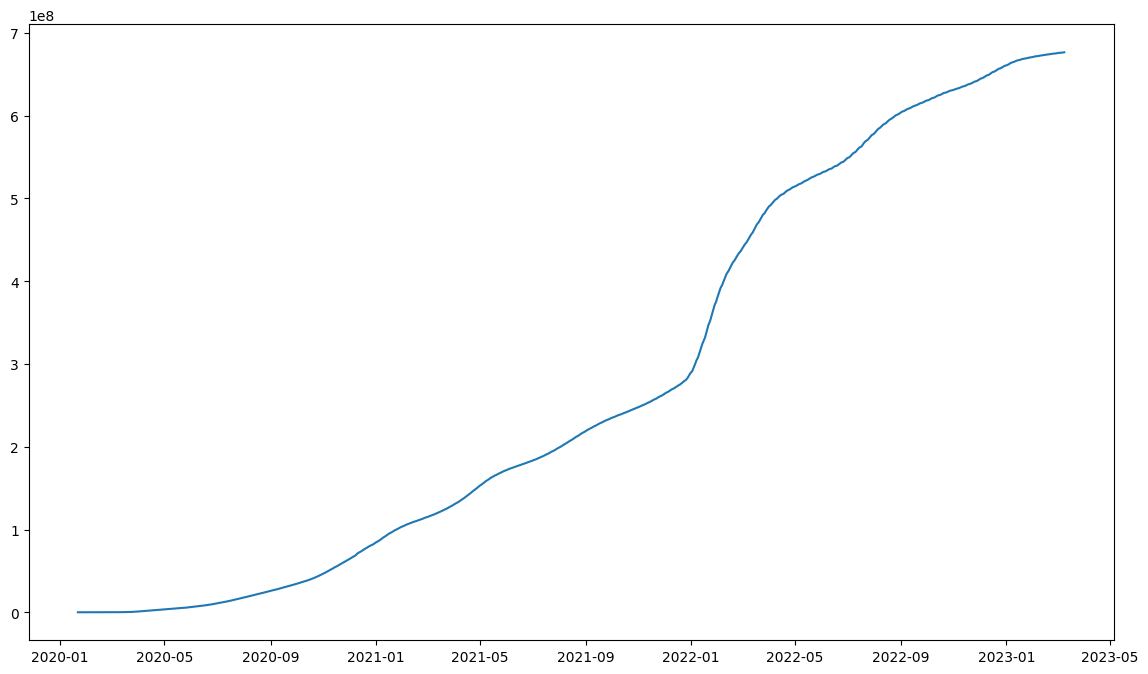

In [18]:
plt.figure(figsize = (14,8))
plt.plot(confirmed_cases['ds'],confirmed_cases['y'])
plt.show()

In [57]:
train = confirmed_cases[:710] #Before
test = confirmed_cases[710:] #test, remember this is sequential data.

In [20]:
test

,ds,y
710,2022-01-01,289931428
711,2022-01-02,290849939
712,2022-01-03,293188320
713,2022-01-04,295801747
714,2022-01-05,298385756
...,...,...
1138,2023-03-05,676024901
1139,2023-03-06,676082941
1140,2023-03-07,676213378
1141,2023-03-08,676392824


In [21]:
train

,ds,y
0,2020-01-22,557
1,2020-01-23,657
2,2020-01-24,944
3,2020-01-25,1437
4,2020-01-26,2120
...,...,...
705,2021-12-27,282033889
706,2021-12-28,283370260
707,2021-12-29,285075127
708,2021-12-30,287025253


Please check out the FB prophet documentation here: https://facebook.github.io/prophet/docs/quick_start.html

In [58]:
# Model Initialize

# !pip install prophet # if you havn't done so
import prophet
from prophet import Prophet

In [23]:
#Check out all the available functions in fb prophet. 
dir(Prophet)

['__class__',
 '__delattr__',
 '__dict__',
 '__dir__',
 '__doc__',
 '__eq__',
 '__format__',
 '__ge__',
 '__getattribute__',
 '__gt__',
 '__hash__',
 '__init__',
 '__init_subclass__',
 '__le__',
 '__lt__',
 '__module__',
 '__ne__',
 '__new__',
 '__reduce__',
 '__reduce_ex__',
 '__repr__',
 '__setattr__',
 '__sizeof__',
 '__str__',
 '__subclasshook__',
 '__weakref__',
 '_load_stan_backend',
 '_logistic_uncertainty',
 '_make_historical_mat_time',
 '_make_trend_shift_matrix',
 '_sample_uncertainty',
 'add_country_holidays',
 'add_group_component',
 'add_regressor',
 'add_seasonality',
 'construct_holiday_dataframe',
 'fit',
 'flat_growth_init',
 'flat_trend',
 'fourier_series',
 'initialize_scales',
 'linear_growth_init',
 'logistic_growth_init',
 'make_all_seasonality_features',
 'make_future_dataframe',
 'make_holiday_features',
 'make_seasonality_features',
 'parse_seasonality_args',
 'percentile',
 'piecewise_linear',
 'piecewise_logistic',
 'plot',
 'plot_components',
 'predict',
 'p

In [59]:
# Initialize Model
m = Prophet(interval_width = 0.95, daily_seasonality= False) #I don't think there is daily seasonality for Covid so we're not sure.

In [60]:
# Fourier order helps with seasonality. 3 for weekly seasonality and 10 for yearly seasonality. You will have to play around
# By increasing the value of fourier_order, more terms are included in the model, 
# making it more flexible and allowing it to capture more complex seasonality patterns. 
# However, a larger value of fourier_order can also result in overfitting and increased computation time. 
# The appropriate value of fourier_order depends on the frequency and 
# nature of the time series being modeled and is usually determined through experimentation.
m.add_seasonality(name="monthly",period=30.5,fourier_order=5)

A higher order means we have higher frequency terms and so will be able to fit more quickly-changing and complex seasonality patterns. For yearly patterns, choose 10, for weekly, 3.

In [61]:
# Fit Model
m.fit(train)

INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp4af3m4lj/l5xmnth5.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp4af3m4lj/9ge_v96p.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=79684', 'data', 'file=/tmp/tmp4af3m4lj/l5xmnth5.json', 'init=/tmp/tmp4af3m4lj/9ge_v96p.json', 'output', 'file=/tmp/tmp4af3m4lj/prophet_modeltdizih0j/prophet_model-20230602173425.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
17:34:25 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
17:34:25 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


In [62]:
# Future Date
future_dates = m.make_future_dataframe(periods=30) #predict the future by 30 timesteps
future_dates   #includes the Train Dates + 30 days 

,ds
0,2020-01-22
1,2020-01-23
2,2020-01-24
3,2020-01-25
4,2020-01-26
...,...
735,2022-01-26
736,2022-01-27
737,2022-01-28
738,2022-01-29


In [64]:
# Prediction
prediction =  m.predict(future_dates)

In [65]:
prediction

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,monthly,monthly_lower,monthly_upper,weekly,weekly_lower,weekly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
0,2020-01-22,-1.223255e+05,-1.565991e+06,1.534016e+06,-1.223255e+05,-1.223255e+05,83282.538428,83282.538428,83282.538428,98784.639849,98784.639849,98784.639849,-15502.101421,-15502.101421,-15502.101421,0.0,0.0,0.0,-3.904298e+04
1,2020-01-23,-1.161390e+05,-1.488157e+06,1.642662e+06,-1.161390e+05,-1.161390e+05,156091.994545,156091.994545,156091.994545,103338.338779,103338.338779,103338.338779,52753.655765,52753.655765,52753.655765,0.0,0.0,0.0,3.995300e+04
2,2020-01-24,-1.099525e+05,-1.565185e+06,1.657641e+06,-1.099525e+05,-1.099525e+05,214430.113273,214430.113273,214430.113273,96327.214554,96327.214554,96327.214554,118102.898720,118102.898720,118102.898720,0.0,0.0,0.0,1.044776e+05
3,2020-01-25,-1.037659e+05,-1.609807e+06,1.634874e+06,-1.037659e+05,-1.037659e+05,131528.088022,131528.088022,131528.088022,106333.472880,106333.472880,106333.472880,25194.615142,25194.615142,25194.615142,0.0,0.0,0.0,2.776214e+04
4,2020-01-26,-9.757942e+04,-1.601968e+06,1.526702e+06,-9.757942e+04,-9.757942e+04,104147.966388,104147.966388,104147.966388,150951.817122,150951.817122,150951.817122,-46803.850734,-46803.850734,-46803.850734,0.0,0.0,0.0,6.568543e+03
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
735,2022-01-26,2.944234e+08,2.901482e+08,2.986077e+08,2.901308e+08,2.984429e+08,90831.371459,90831.371459,90831.371459,106333.472880,106333.472880,106333.472880,-15502.101421,-15502.101421,-15502.101421,0.0,0.0,0.0,2.945142e+08
736,2022-01-27,2.949449e+08,2.903883e+08,2.996342e+08,2.904591e+08,2.991598e+08,203705.472887,203705.472887,203705.472887,150951.817122,150951.817122,150951.817122,52753.655765,52753.655765,52753.655765,0.0,0.0,0.0,2.951487e+08
737,2022-01-28,2.954665e+08,2.909428e+08,3.001485e+08,2.908047e+08,2.998962e+08,331245.527804,331245.527804,331245.527804,213142.629085,213142.629085,213142.629085,118102.898720,118102.898720,118102.898720,0.0,0.0,0.0,2.957977e+08
738,2022-01-29,2.959880e+08,2.911830e+08,3.007035e+08,2.911503e+08,3.006849e+08,272595.706991,272595.706991,272595.706991,247401.091849,247401.091849,247401.091849,25194.615142,25194.615142,25194.615142,0.0,0.0,0.0,2.962606e+08


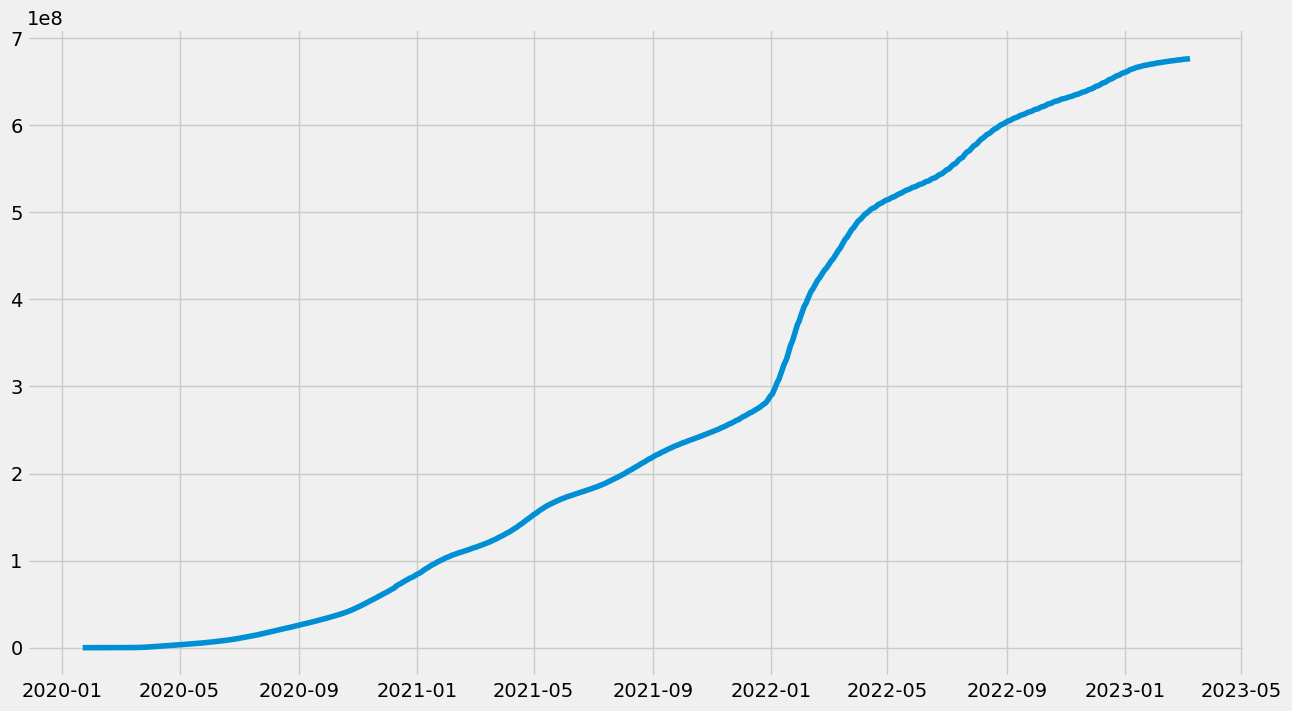

In [66]:
plt.figure(figsize = (14,8))
plt.plot(confirmed_cases['ds'],confirmed_cases['y'])
plt.show()

We can see a few interesting features:
- yhat_lower is lower bound prediction
- yhat_upper is upper bound prediction
- Both are within a 95% confidence interval 
- yhat is the actual prediction

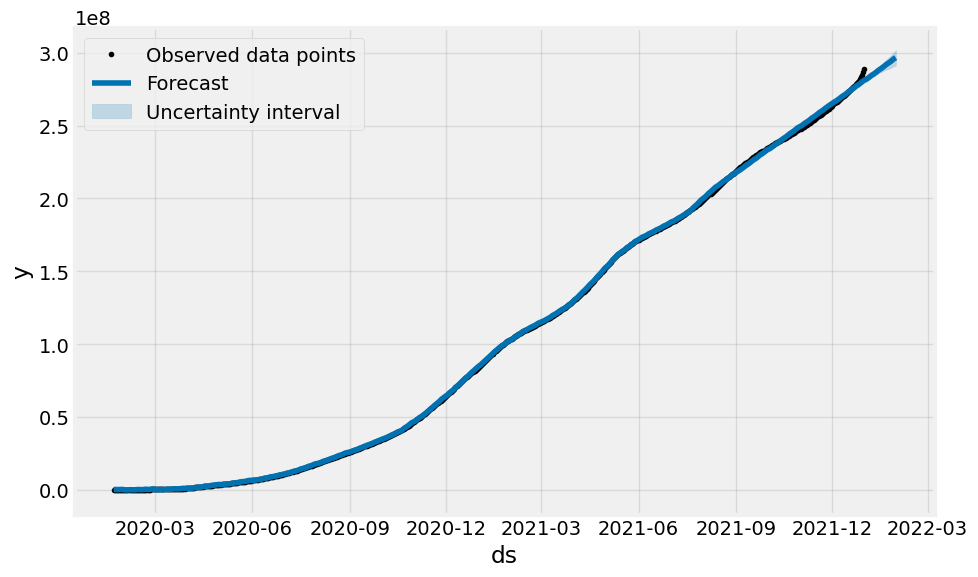

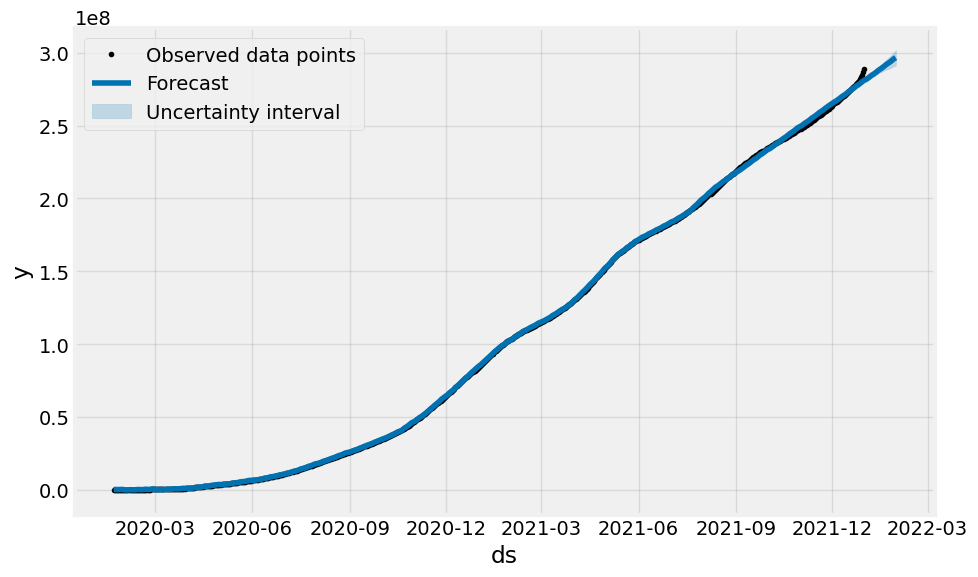

In [67]:
# Plot Prediction
m.plot(prediction, include_legend=True)  #notice the wider confidence intervals the further you go out into the future

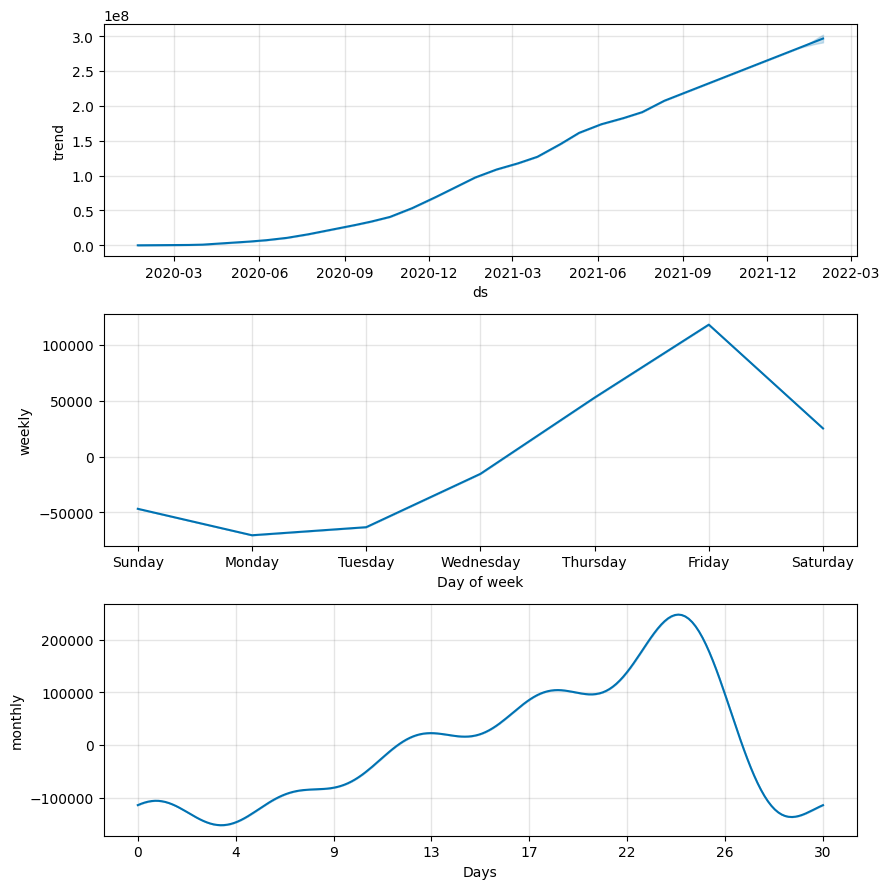

In [32]:
m.plot_components(prediction);

In [68]:
test['dates'] = pd.to_datetime(test['ds'])

<ipython-input-68-a3eb9f631ca6>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test['dates'] = pd.to_datetime(test['ds'])


Real time series frequently have abrupt changes in their trajectories.Prophet tries to detect these changepoints and will allow the trend to adapt appropriately, to see the points that create changes, we can do a changepoints plot.

In [69]:
# Find Point/Dates For Change
from prophet.plot import add_changepoints_to_plot

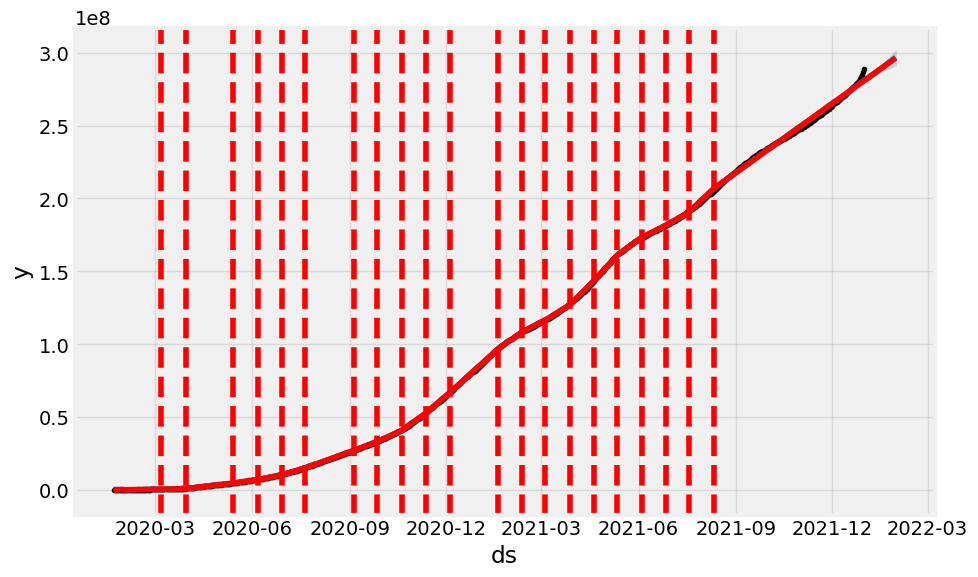

In [70]:
fig = m.plot(prediction)
c = add_changepoints_to_plot(fig.gca(),m,prediction)

## Example 2: Sales Data

Demo from [here](https://github.com/nicknochnack/TimeSeriesForecastingProphet/blob/main/Facebook%20Prophet.ipynb)


In [72]:
df = pd.read_csv("https://raw.githubusercontent.com/nicknochnack/TimeSeriesForecastingProphet/main/dataset.csv")

In [73]:
# Preprocess the data


df['Year'] = df['Time Date'].apply(lambda x: str(x)[-4:])
df['Month'] = df['Time Date'].apply(lambda x: str(x)[-6:-4])
df['Day'] = df['Time Date'].apply(lambda x: str(x)[:-6])
df['ds'] = pd.DatetimeIndex(df['Year']+'-'+df['Month']+'-'+df['Day'])

df = df.loc[(df['Product']==2667437) & (df['Store']=='QLD_CW_ST0203')]
df.drop(['Time Date', 'Product', 'Store', 'Year', 'Month', 'Day'], axis=1, inplace=True)
df.columns = ['y', 'ds']

df.head()

,y,ds
0,2926.000,2018-01-01
1,2687.531,2018-01-02
2,2793.000,2018-01-03
3,2394.000,2018-01-04
4,2660.000,2018-01-05


In [74]:
#Instatiate model
m = Prophet(interval_width=0.95, daily_seasonality=False)
m.add_seasonality(name="monthly",period=30.5,fourier_order=5)

#Fit
model = m.fit(df)

DEBUG:cmdstanpy:input tempfile: /tmp/tmp4af3m4lj/8nrw1qpl.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp4af3m4lj/k4bmfrx5.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=99237', 'data', 'file=/tmp/tmp4af3m4lj/8nrw1qpl.json', 'init=/tmp/tmp4af3m4lj/k4bmfrx5.json', 'output', 'file=/tmp/tmp4af3m4lj/prophet_modelusxh5j5l/prophet_model-20230602181309.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
18:13:09 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
18:13:10 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


In [75]:
#Forcast into the future
future = m.make_future_dataframe(periods=365)

forecast = m.predict(future)
forecast.head()

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,monthly,...,weekly,weekly_lower,weekly_upper,yearly,yearly_lower,yearly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
0,2018-01-01,3509.410696,1037.402697,4089.097035,3509.410696,3509.410696,-979.377231,-979.377231,-979.377231,120.256666,...,15.930720,15.930720,15.930720,-1115.564617,-1115.564617,-1115.564617,0.0,0.0,0.0,2530.033465
1,2018-01-02,3510.172894,1045.615338,4101.582917,3510.172894,3510.172894,-1012.947427,-1012.947427,-1012.947427,93.705830,...,-10.836437,-10.836437,-10.836437,-1095.816820,-1095.816820,-1095.816820,0.0,0.0,0.0,2497.225467
2,2018-01-03,3510.935093,888.046312,4043.400546,3510.935093,3510.935093,-1001.886078,-1001.886078,-1001.886078,76.557180,...,-3.251302,-3.251302,-3.251302,-1075.191956,-1075.191956,-1075.191956,0.0,0.0,0.0,2509.049015
3,2018-01-04,3511.697291,972.533239,4026.898513,3511.697291,3511.697291,-964.714234,-964.714234,-964.714234,66.899625,...,22.178880,22.178880,22.178880,-1053.792740,-1053.792740,-1053.792740,0.0,0.0,0.0,2546.983057
4,2018-01-05,3512.459490,1074.972351,4125.492326,3512.459490,3512.459490,-997.111702,-997.111702,-997.111702,69.915169,...,-35.260014,-35.260014,-35.260014,-1031.766857,-1031.766857,-1031.766857,0.0,0.0,0.0,2515.347788


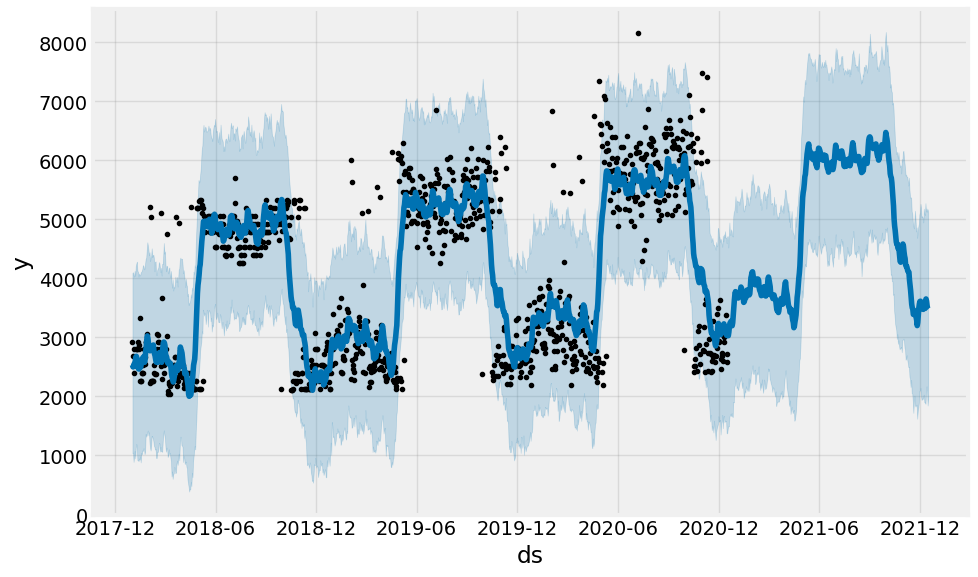

In [76]:
plot1 = m.plot(forecast)

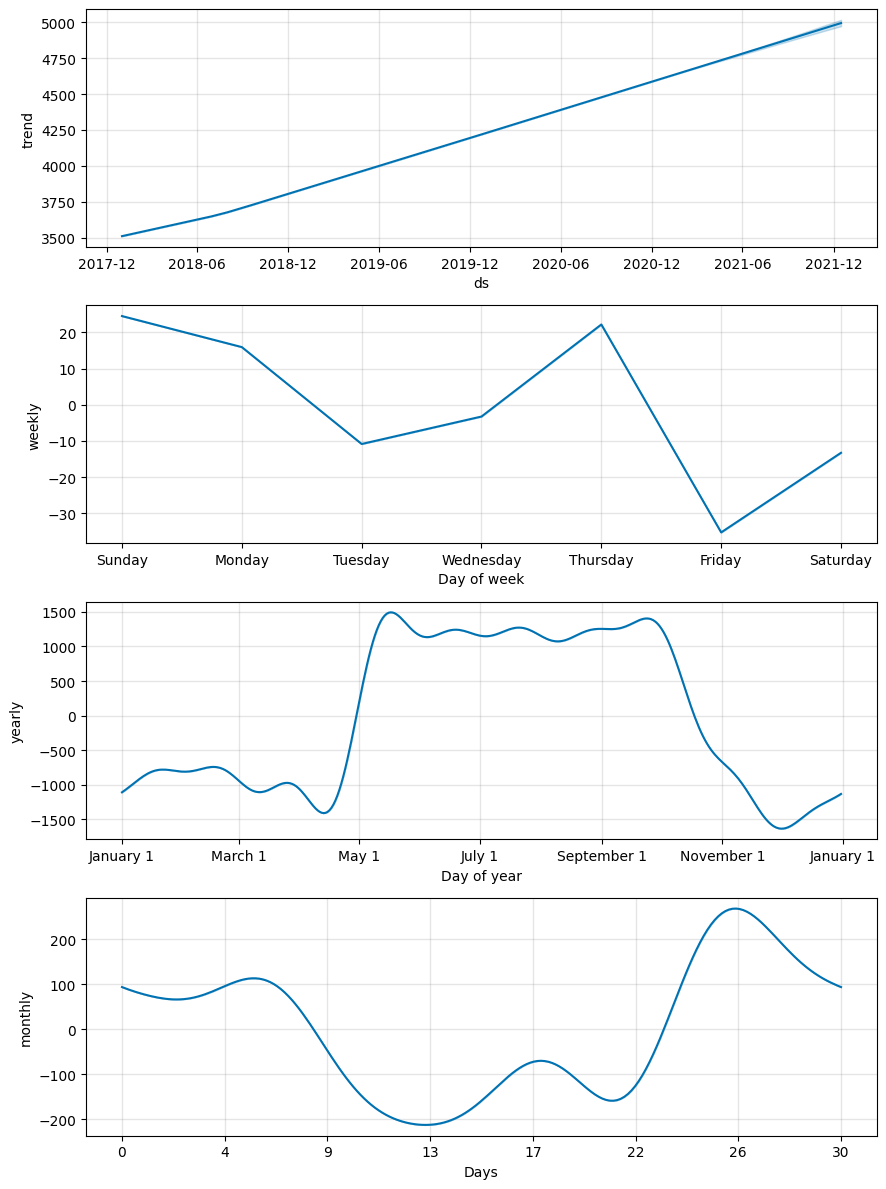

In [41]:
# Decompose your data
plot2 = m.plot_components(forecast)

- The black datapoints are the real observation
- The line is the predicted y-hat

## Time Series Forecasting as Supervised Learning

Review:
* What is Supervised Learning? 
    
* How is data given in SL?

Supervised learning is where you have input variables (X) and an output variable (y) and you use an algorithm to learn the mapping function from the input to the output.

$Y = f(X)$

### Sliding Window For Time Series Data

The reason we can't usually use SL models the same way in TS is because Time Series are not independent variables.

One step usually depends on the previous step.

However, given a sequence of numbers for a Time Series set, the data can be forced to look like a supervised learning problem.

**How?**
We can use previous time steps as input variables and use the next time step as the output variable.

|time  |  measure |
| ---- | -------- |
| 1 | 100 |
| 2 | 110 |
| 3 | 108 |
| 4 | 115 |
| 5 | 120 |

We restructure this dataset as a supervised learning problem like this:
- The X is the day prior's Y is used to predict the y. 
- or
- The X of today is today's Y used to predict the y of tomorrow.

| X    |   y      |
| ---- | -------- |
|? | 100 | 
|100 | 110 | 
|110 |   108 | 
|108 | 115 | 
|115 | 120 | 
|120 | ? | 


**What do you observe?**

* Can't use first value
* Can't use last value
* Do you think the order needs to be preserved? Why or why not?

**Why do we care?**

* We already know how to calculate TS with different statistical models. Why would we use ML?

**Advantages**
* Sometimes TS have a lot of variables. That's when SL comes in useful.

| time| measure1| measure2| 
|----|----|----|
| 1| 0.2| 88| 
| 2| 0.5| 89| 
| 3| 0.7| 87| 
| 4| 0.4| 88| 
| 5| 1.0| 90| 

We will use the previous time step values of measure1 and measure2. 
We also have available the next time step value for measure1. 
We can then predict the next time step value of measure2.



|X1 | X2 | X3 |  y | 
|---|---|---|---|
|? | ? | 0.2  |  88 | 
|0.2 | 88 |  0.5 |  89 | 
|0.5 | 89 |  0.7 |  87 | 
|0.7 | 87 |  0.4 |  88 | 
|0.4 | 88 |  1.0 |  90 | 
|1.0 | 90 |  ? |  ? | 

For multiple output predictions, you can use ANNs, think of predicting more than one value as predicting a sequence. 

In this case, we were predicting two different output variables, but we may want to predict multiple time-steps ahead of one output variable.

In [81]:
from pandas import DataFrame
df = DataFrame()
df['t'] = [x for x in range(10)]
df['t+3']= df['t'].shift(-3)
print(df)

   t  t+3
0  0  3.0
1  1  4.0
2  2  5.0
3  3  6.0
4  4  7.0
5  5  8.0
6  6  9.0
7  7  NaN
8  8  NaN
9  9  NaN


We can see that the forecast column can be taken as an input (X) and the second as an output value (y). That is the input value of 0 can be used to forecast the output value of 1.

Further, the shift function also works on so-called multivariate time series problems. That is where instead of having one set of observations for a time series, we have multiple (e.g. temperature and pressure). All variates in the time series can be shifted forward or backward to create multivariate input and output sequences. We will explore this more later in the tutorial

There are many SL models you can use. For example, linear regression as long as:

* The inclusion of lagged terms as regressors does not create a collinearity problem.
* Both the regressors and the explained variable are stationary
* Your errors are not correlated with each other


Based on tutorial from [here](https://blog.jcharistech.com/2020/03/13/predicting-coronavirus-outbreak-with-facebook-prophets-a-timeseries-forecast/)

### LSTM for Time Series

In [82]:
import math
import pandas_datareader as web
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense,LSTM, Dropout
import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')

In [83]:
#Download data from here! https://ca.finance.yahoo.com/
df = pd.read_csv("./BTC-CAD.csv")

In [84]:
df.head()

,Date,Open,High,Low,Close,Adj Close,Volume
0,2021-11-14,80899.226563,82171.757813,79885.640625,82136.203125,82136.203125,31518754671
1,2021-11-15,82204.515625,83065.789063,79546.390625,79543.437500,79543.437500,38244659286
2,2021-11-16,79747.843750,79747.843750,73947.171875,75600.125000,75600.125000,58865763213
3,2021-11-17,75572.953125,76447.250000,73526.953125,76131.671875,76131.671875,49408889963
4,2021-11-18,76121.742188,76860.750000,71259.539063,71765.257813,71765.257813,52162509641


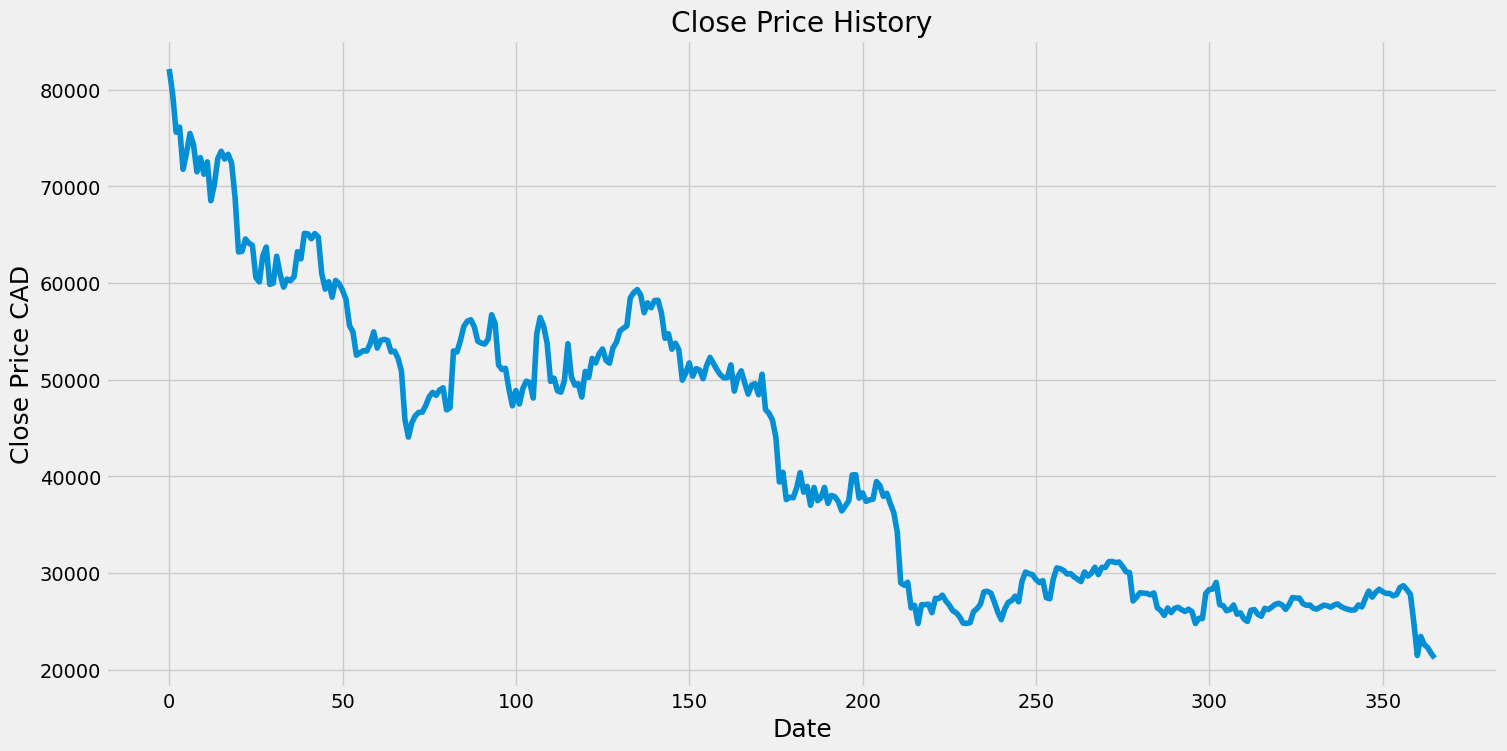

In [85]:
plt.figure(figsize=(16,8))
plt.title('Close Price History')
plt.plot(df['Close'])
plt.xlabel('Date',fontsize=18)
plt.ylabel('Close Price CAD',fontsize=18)
plt.show()

In [86]:
data = df.filter(['Close'])
training_data_len = math.ceil(len(data) * .8)
train_data = data.iloc[0:training_data_len,:]
test_data = data.iloc[training_data_len - numDays:,:]

In [87]:
scaler = MinMaxScaler(feature_range=(0,1))
scaled_train_data = scaler.fit_transform(train_data)

In [88]:
scaled_test_data = scaler.transform(test_data)

In [89]:
x_train =[]
y_train=[]

numDays = 14  #how many days in the past we using to make predictions

for i in range(numDays,len(scaled_train_data) -1):
  x_train.append(scaled_train_data[i-numDays:i, 0])
  y_train.append(scaled_train_data[i + 1,0])

In [90]:
#convert train data to numpy arrays
x_train,y_train=np.array(x_train),np.array(y_train)

#Reshape
x_train.shape

(278, 14)

In [91]:
x_train=np.reshape(x_train,(x_train.shape[0],x_train.shape[1],1))
x_train.shape

(278, 14, 1)

In [92]:
# build LSTM model
model=Sequential()
model.add(LSTM(50,return_sequences=True,input_shape=(x_train.shape[1], 1)))
model.add(Dropout(0.2))
model.add(LSTM(50,return_sequences=False))
model.add(Dropout(0.2))
model.add(Dense(25))
model.add(Dense(25))
model.add(Dense(1))
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 14, 50)            10400     
                                                                 
 dropout (Dropout)           (None, 14, 50)            0         
                                                                 
 lstm_1 (LSTM)               (None, 50)                20200     
                                                                 
 dropout_1 (Dropout)         (None, 50)                0         
                                                                 
 dense (Dense)               (None, 25)                1275      
                                                                 
 dense_1 (Dense)             (None, 25)                650       
                                                                 
 dense_2 (Dense)             (None, 1)                 2

In [100]:
#compile the model
model.compile(optimizer='adam',loss='mean_squared_error')
#train the model
model.fit(x_train,y_train,batch_size=7,epochs=10)

Epoch 1/10
40/40 [==============================] - 6s 16ms/step - loss: 0.0064
Epoch 2/10
40/40 [==============================] - 1s 17ms/step - loss: 0.0048
Epoch 3/10
40/40 [==============================] - 1s 16ms/step - loss: 0.0039
Epoch 4/10
40/40 [==============================] - 1s 16ms/step - loss: 0.0043
Epoch 5/10
40/40 [==============================] - 1s 16ms/step - loss: 0.0037
Epoch 6/10
40/40 [==============================] - 1s 17ms/step - loss: 0.0047
Epoch 7/10
40/40 [==============================] - 1s 17ms/step - loss: 0.0039
Epoch 8/10
40/40 [==============================] - 1s 17ms/step - loss: 0.0036
Epoch 9/10
40/40 [==============================] - 1s 17ms/step - loss: 0.0039
Epoch 10/10
40/40 [==============================] - 1s 22ms/step - loss: 0.0032


In [101]:
x_test =[]
y_test=[]

numDays = 14

for i in range(numDays,len(scaled_test_data) -1):
  x_test.append(scaled_test_data[i-numDays:i, 0])
  y_test.append(scaled_test_data[i + 1,0])

In [110]:
data.shift(-14)

,Close
0,72853.359375
1,73636.023438
2,72827.109375
3,73320.281250
4,72396.257813
...,...
361,NaN
362,NaN
363,NaN
364,NaN


In [102]:
x_test,y_test=np.array(x_test),np.array(y_test)

In [103]:
#reshape
x_test=np.reshape(x_test,(x_test.shape[0],x_test.shape[1],1))

In [104]:
x_test.shape

(72, 14, 1)

In [105]:
predictions=model.predict(x_test)
predictions=scaler.inverse_transform(predictions)

3/3 [==============================] - 1s 13ms/step


<ipython-input-106-1dfe8d4cfe65>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  valid['Predictions']=predictions


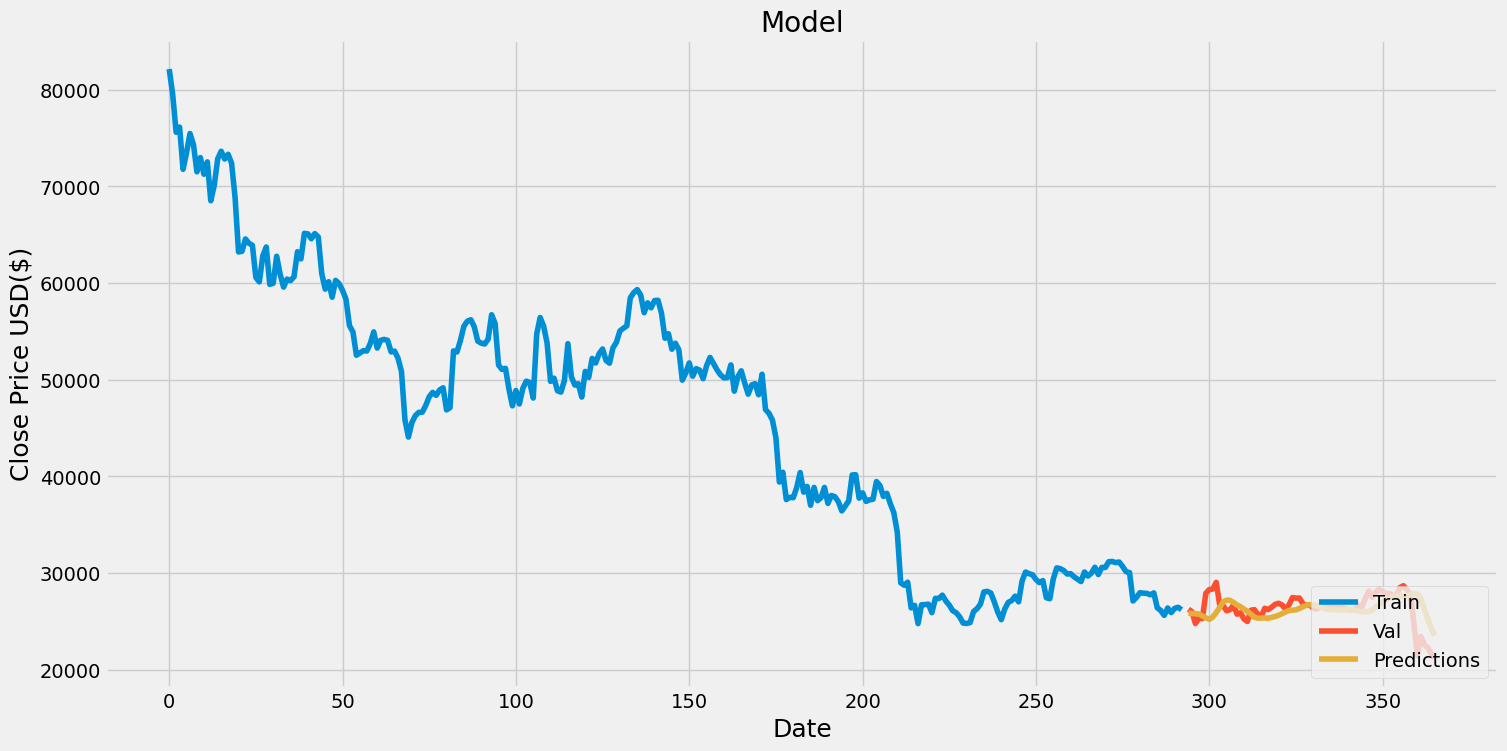

In [106]:
train=data[:training_data_len]
valid=data[training_data_len+1:]
valid['Predictions']=predictions

#visualize the data
plt.figure(figsize=(16,8))
plt.title('Model')
plt.xlabel('Date',fontsize=18)
plt.ylabel('Close Price USD($)',fontsize=18)
plt.plot(train['Close'])
plt.plot(valid[['Close','Predictions']])
plt.legend(['Train','Val','Predictions'],loc='lower right')
plt.show()

Resources
https://research.fb.com/prophet-forecasting-at-scale/